# Data Acquisition and Preprocessing

### Import Libraries

In [532]:
# Import necessary libraries
import math
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from scipy.stats import f_oneway
from sklearn.impute import SimpleImputer

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

# Set the style for our visualizations
plt.style.use('ggplot')

In [497]:
print(Diabetes.columns.tolist())

['age', 'gender', 'polyuria', 'polydipsia', 'sudden_weight_loss', 'weakness', 'polyphagia', 'genital_thrush', 'visual_blurring', 'itching', 'irritability', 'delayed_healing', 'partial_paresis', 'muscle_stiffness', 'alopecia', 'obesity', 'class', 'class_label', 'Age_Obesity_Ratio']


### Load Dataset

In [498]:
# Load the dataset
Diabetes= pd.read_csv('diabetes_data_upload.csv') # loading the dataset

Diabetes = Diabetes.copy()
Diabetes['class'] = Diabetes['class'].map({'Positive': 1, 'Negative': 0})

# Assign proper column names
Diabetes.columns = [
    'age', 'gender', 'polyuria', 'polydipsia', 'sudden_weight_loss',
    'weakness', 'polyphagia', 'genital_thrush', 'visual_blurring',
    'itching', 'irritability', 'delayed_healing', 'partial_paresis',
    'muscle_stiffness', 'alopecia', 'obesity', 'class'
]
# Display the first few rows of the dataset
print("Dataset Shape:", Diabetes.shape)
print("\nColumn Names:", Diabetes.columns.tolist())
print("\nFirst 5 rows of the dataset:")
Diabetes.head() # Displays top 10 records of the dataset

Dataset Shape: (520, 17)

Column Names: ['age', 'gender', 'polyuria', 'polydipsia', 'sudden_weight_loss', 'weakness', 'polyphagia', 'genital_thrush', 'visual_blurring', 'itching', 'irritability', 'delayed_healing', 'partial_paresis', 'muscle_stiffness', 'alopecia', 'obesity', 'class']

First 5 rows of the dataset:


,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,1
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,1
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,1
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,1
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,1


### Initial Inspection

In [499]:
# Display concise summary of the dataset
print(Diabetes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 520 non-null    int64 
 1   gender              520 non-null    object
 2   polyuria            520 non-null    object
 3   polydipsia          520 non-null    object
 4   sudden_weight_loss  520 non-null    object
 5   weakness            520 non-null    object
 6   polyphagia          520 non-null    object
 7   genital_thrush      520 non-null    object
 8   visual_blurring     520 non-null    object
 9   itching             520 non-null    object
 10  irritability        520 non-null    object
 11  delayed_healing     520 non-null    object
 12  partial_paresis     520 non-null    object
 13  muscle_stiffness    520 non-null    object
 14  alopecia            520 non-null    object
 15  obesity             520 non-null    object
 16  class               520 no

In [500]:
# Check for missing values
print("Missing Values (isnull):")
print(Diabetes.isnull().sum())

Missing Values (isnull):
age                   0
gender                0
polyuria              0
polydipsia            0
sudden_weight_loss    0
weakness              0
polyphagia            0
genital_thrush        0
visual_blurring       0
itching               0
irritability          0
delayed_healing       0
partial_paresis       0
muscle_stiffness      0
alopecia              0
obesity               0
class                 0
dtype: int64


In [501]:
# Check for null values
print("Null Values (isna):")
print(Diabetes.isna().sum())

Null Values (isna):
age                   0
gender                0
polyuria              0
polydipsia            0
sudden_weight_loss    0
weakness              0
polyphagia            0
genital_thrush        0
visual_blurring       0
itching               0
irritability          0
delayed_healing       0
partial_paresis       0
muscle_stiffness      0
alopecia              0
obesity               0
class                 0
dtype: int64


In [502]:
# Check for basic statistics
print("Basic Statistics:")
Diabetes.describe().T

Basic Statistics:


,count,mean,std,min,25%,50%,75%,max
age,520.0,48.028846,12.151466,16.0,39.0,47.5,57.0,90.0
class,520.0,0.615385,0.486973,0.0,0.0,1.0,1.0,1.0


### Handle Missing and Biologically Invalid Values


In [503]:
# Verify your 'class' column values
print("Current class value counts:")
print(Diabetes['class'].value_counts())

# Create label column (only if needed for visualization)
if Diabetes['class'].dtype == 'int64':
    Diabetes['class_label'] = Diabetes['class'].map({1: 'Positive', 0: 'Negative'})
else:
    Diabetes['class_label'] = Diabetes['class'].str.strip().str.title()  # Clean text labels

# Safer zero replacement function
def replace_zeros_with_median(df, columns):
    df_processed = df.copy()
    actual_columns = [col for col in columns if col in df_processed.columns]
    
    if not actual_columns:
        print("Warning: None of the specified columns exist in the DataFrame")
        return df_processed
        
    for column in actual_columns:
        # Skip non-numeric columns
        if not np.issubdtype(df_processed[column].dtype, np.number):
            print(f"Skipping non-numeric column: {column}")
            continue
            
        zero_count = (df_processed[column] == 0).sum()
        if zero_count > 0:
            df_processed[column] = df_processed[column].replace(0, np.nan)
            medians = df_processed.groupby('class')[column].median()
            
            for outcome in [0, 1]:  # Use numeric class for grouping
                mask = (df_processed['class'] == outcome) & (df_processed[column].isna())
                df_processed.loc[mask, column] = medians.get(outcome, df_processed[column].median())
            print(f"Replaced {zero_count} zeros in {column}")
        else:
            print(f"No zeros found in {column}")
            
    return df_processed

# Only include columns that exist and are numeric
available_numeric_cols = ['Age', 'Insulin', 'BMI']  # From your actual dataset
Diabetes = replace_zeros_with_median(Diabetes, available_numeric_cols)

# Final verification
print("\nFinal zero counts:")
for col in available_numeric_cols:
    if col in Diabetes.columns:
        print(f"{col}: {(Diabetes[col] == 0).sum()} zeros remaining")

Current class value counts:
class
1    320
0    200
Name: count, dtype: int64

Final zero counts:


### Exploratory Data Analysis
We begin by checking for missing values, reviewing column details, and analyzing basic stats. Data encoding is done last to avoid confusion with existing 0/1 values.

In [504]:
fig1 = px.histogram(Diabetes, x='gender', color='class', title='Distribution of Gender by Diabetes Class')
fig1.show()


In [505]:
# Class Distribution (Pie Chart)
fig2 = px.pie(Diabetes, names='class', title='Ratio of Positive and Negative Diabetes Cases')
fig2.show()

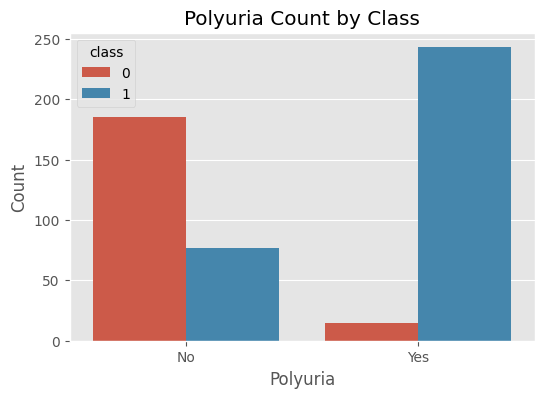

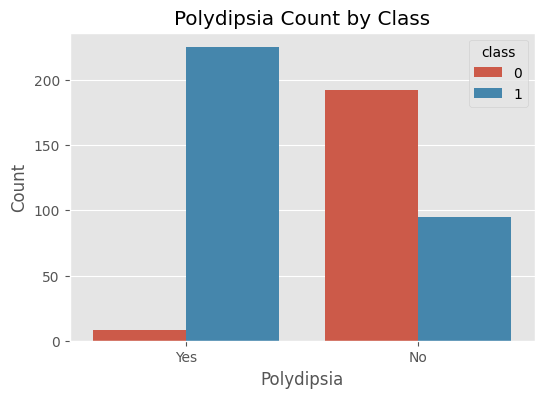

In [506]:
# Polyuria vs Class
plt.figure(figsize=(6,4))
sns.countplot(data=Diabetes, x='polyuria', hue='class')  # <-- lowercase
plt.title('Polyuria Count by Class')
plt.xlabel('Polyuria')
plt.ylabel('Count')
plt.show()

# Polydipsia vs Class
plt.figure(figsize=(6,4))
sns.countplot(data=Diabetes, x='polydipsia', hue='class')  # <-- lowercase
plt.title('Polydipsia Count by Class')
plt.xlabel('Polydipsia')
plt.ylabel('Count')
plt.show()


### Symptom heatmap by class

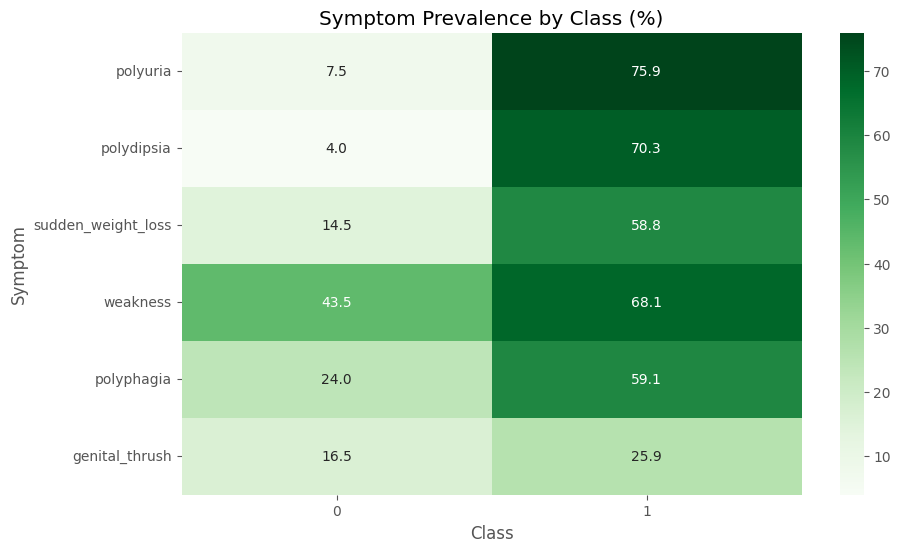

In [507]:
symptoms = ['polyuria', 'polydipsia', 'sudden_weight_loss', 'weakness', 'polyphagia', 'genital_thrush']
symptom_data = Diabetes[symptoms + ['class']].replace({'Yes':1, 'No':0})
heatmap_data = symptom_data.groupby('class').mean().T * 100

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, cmap='Greens', fmt=".1f")
plt.title('Symptom Prevalence by Class (%)')
plt.ylabel('Symptom')
plt.xlabel('Class')
plt.show()

# Analysis for the remaining features

1. Visual blurring
2. Itching
3. Irritability
4. Delayed healing
5. Partial paresis
6. Muscle stiffness
7. Alopecia
8. Obesity

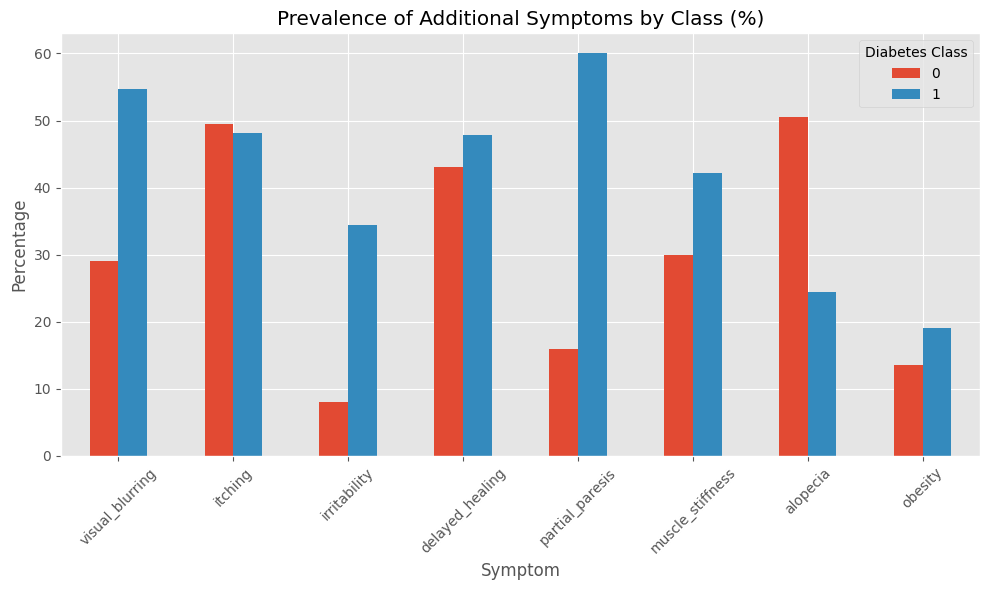

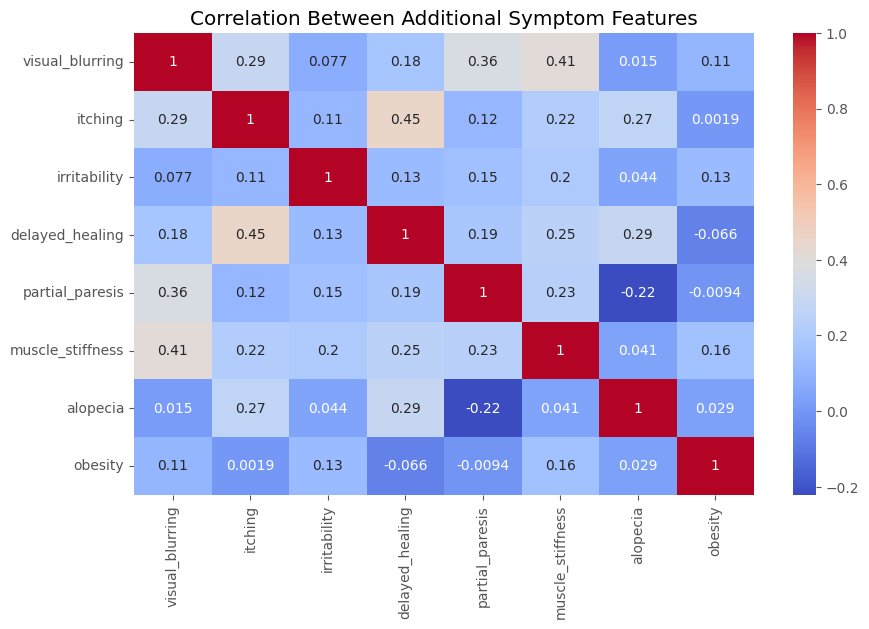

In [508]:
# List of additional symptom features
symptoms_extra = [
    'visual_blurring', 'itching', 'irritability', 'delayed_healing', 
    'partial_paresis', 'muscle_stiffness', 'alopecia', 'obesity'
]

# Convert 'Yes'/'No' to 1/0 for calculation
symptom_data = Diabetes[symptoms_extra + ['class']].replace({'Yes': 1, 'No': 0})

# Grouped Bar Chart - Prevalence by Class
symptom_summary = symptom_data.groupby('class').mean().T * 100

symptom_summary.plot(kind='bar', figsize=(10, 6))
plt.title('Prevalence of Additional Symptoms by Class (%)')
plt.ylabel('Percentage')
plt.xlabel('Symptom')
plt.xticks(rotation=45)
plt.legend(title='Diabetes Class')
plt.tight_layout()
plt.show()

# Correlation Heatmap Among Additional Symptoms
plt.figure(figsize=(10, 6))
sns.heatmap(symptom_data[symptoms_extra].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Additional Symptom Features')
plt.show()


**Observation:** Symptoms such as polyuria and polydipsia appear significantly more common in individuals diagnosed with diabetes, indicating their potential importance as predictive features.

## Feature Analysis and Insights


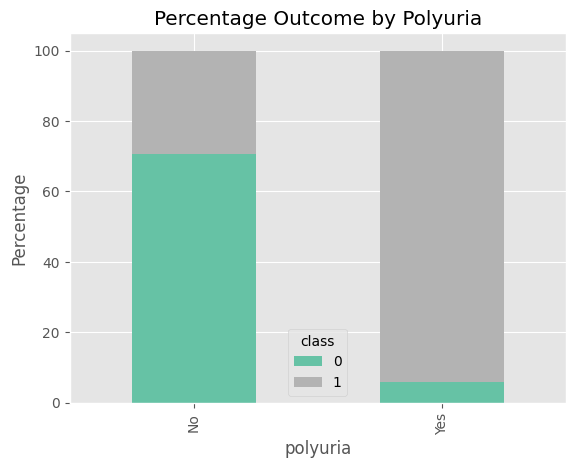

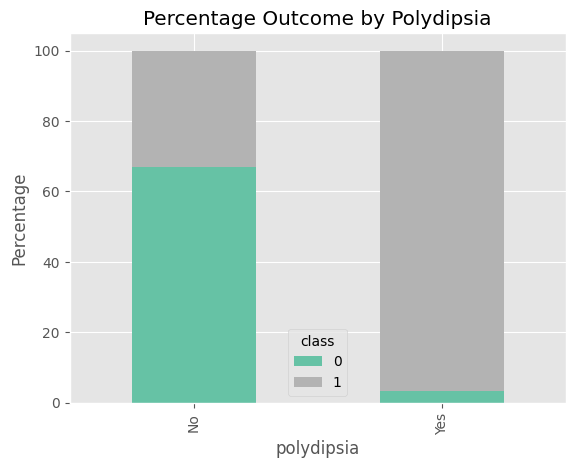

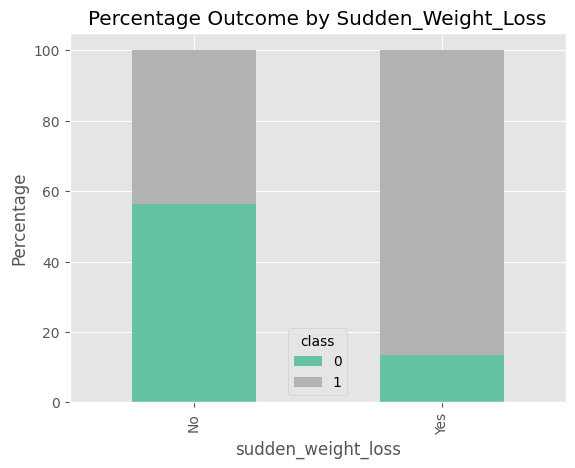

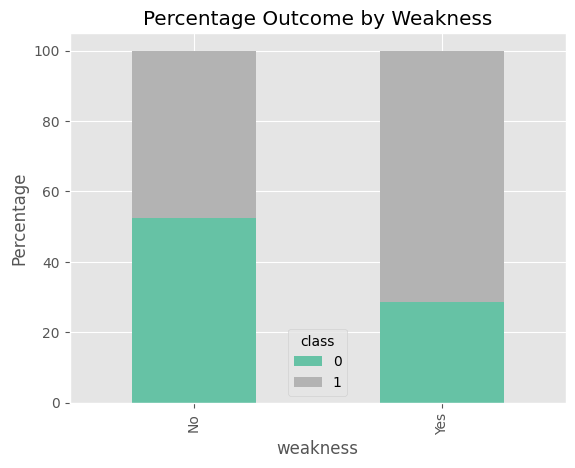

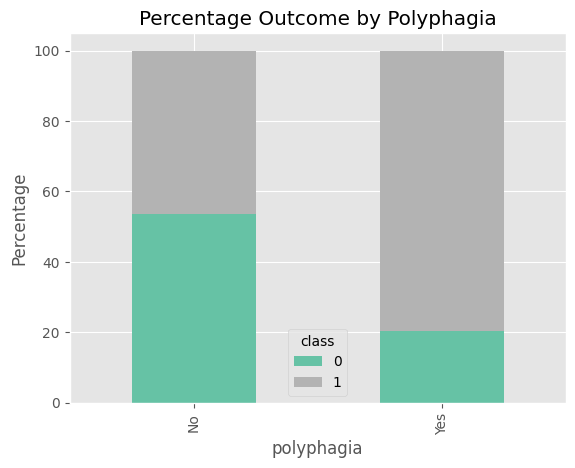

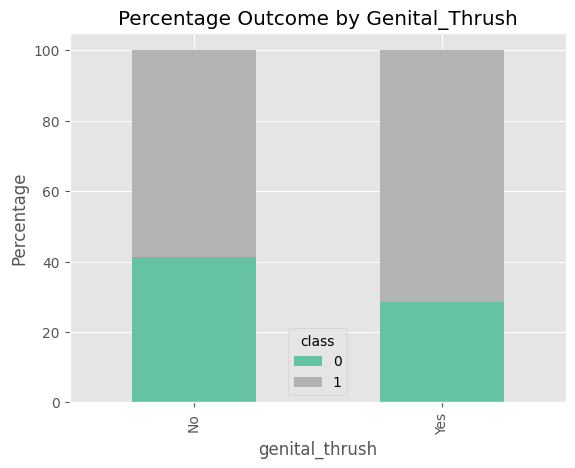

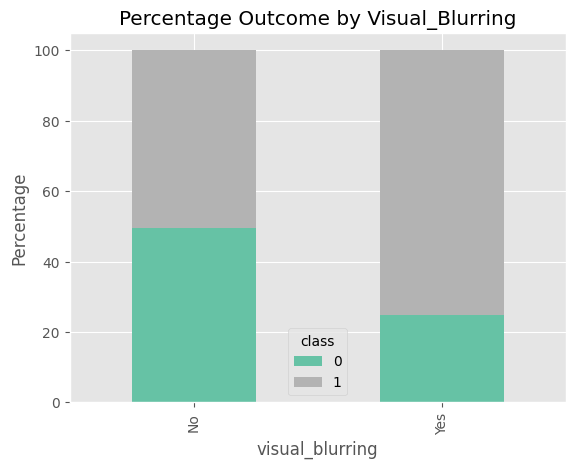

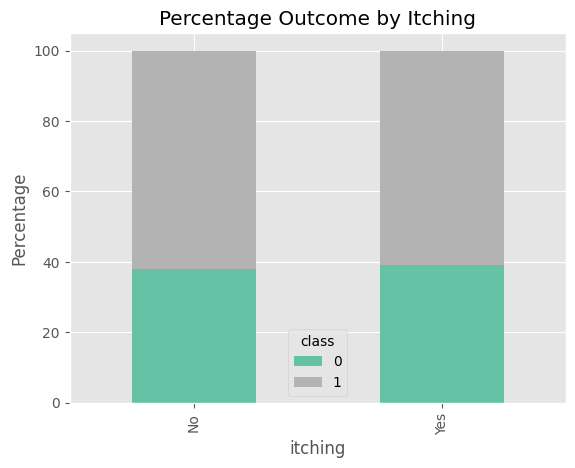

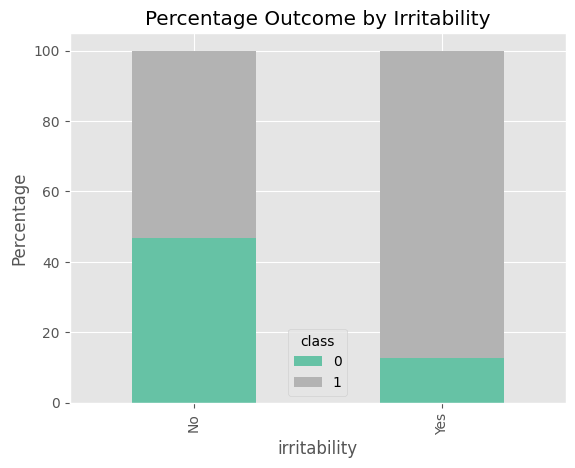

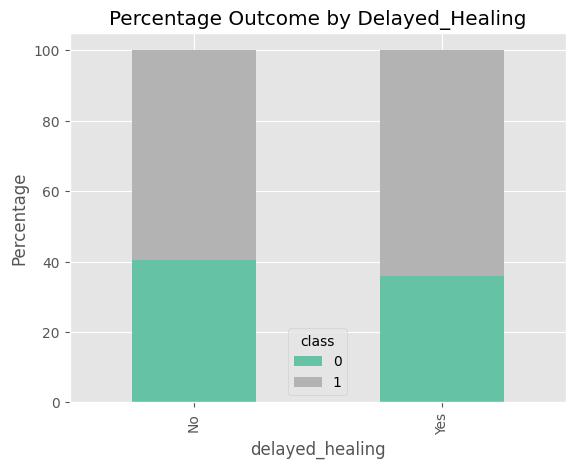

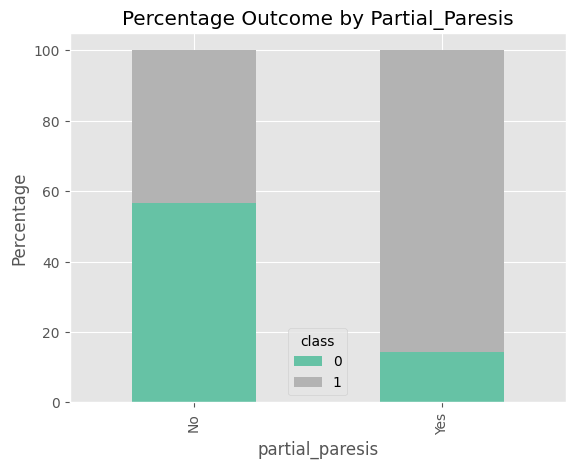

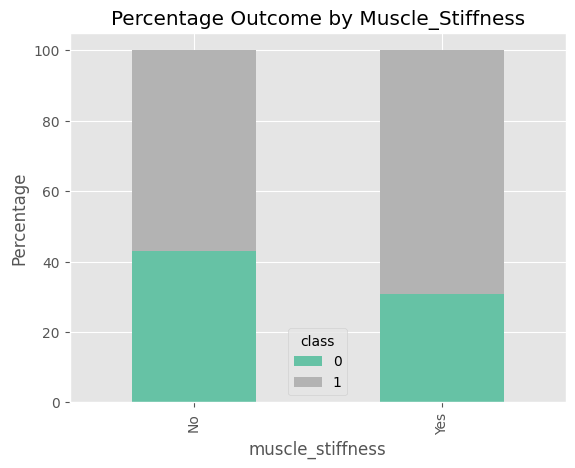

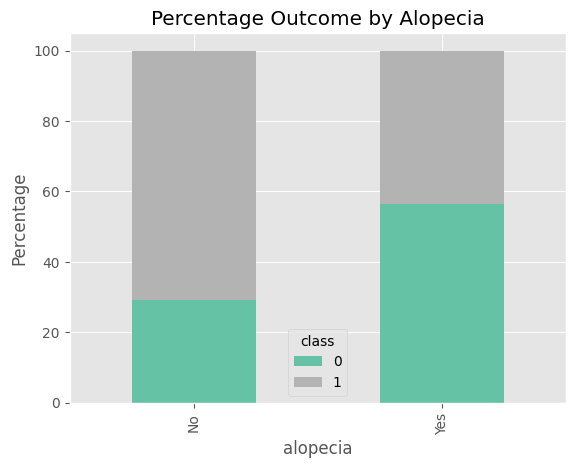

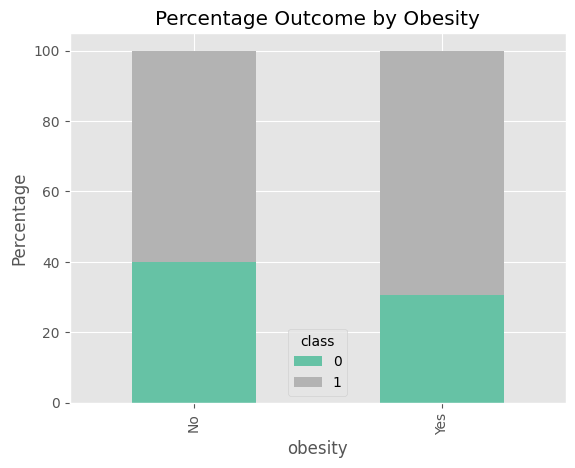

In [509]:
# Stacked bar chart: Percentage of Positive cases per symptom
symptom_cols = ['polyuria', 'polydipsia', 'sudden_weight_loss', 'weakness', 'polyphagia', 
                'genital_thrush', 'visual_blurring', 'itching', 'irritability', 
                'delayed_healing', 'partial_paresis', 'muscle_stiffness', 'alopecia', 'obesity']

for col in symptom_cols:
    counts = pd.crosstab(Diabetes[col], Diabetes['class'], normalize='index') * 100
    counts.plot(kind='bar', stacked=True, title=f'Percentage Outcome by {col.title()}', colormap='Set2')
    plt.ylabel('Percentage')
    plt.show()

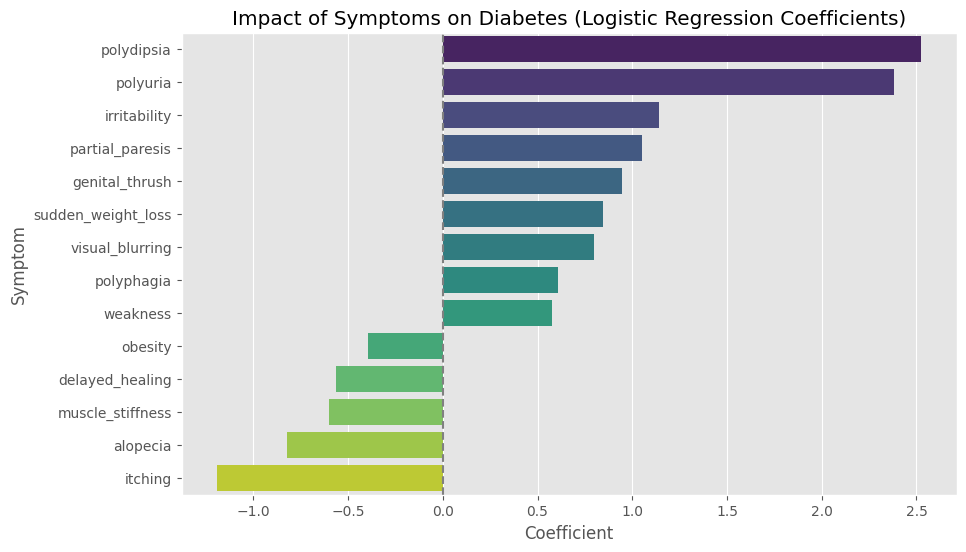

In [510]:
# Logistic regression to estimate feature impact
X_symptoms = Diabetes[symptom_cols].replace({'Yes': 1, 'No': 0})
y_outcome = LabelEncoder().fit_transform(Diabetes['class'])

model = LogisticRegression()
model.fit(X_symptoms, y_outcome)

coef_df = pd.DataFrame({
    'Symptom': symptom_cols,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Symptom', data=coef_df, palette='viridis')
plt.title('Impact of Symptoms on Diabetes (Logistic Regression Coefficients)')
plt.axvline(0, color='gray', linestyle='--')
plt.show()

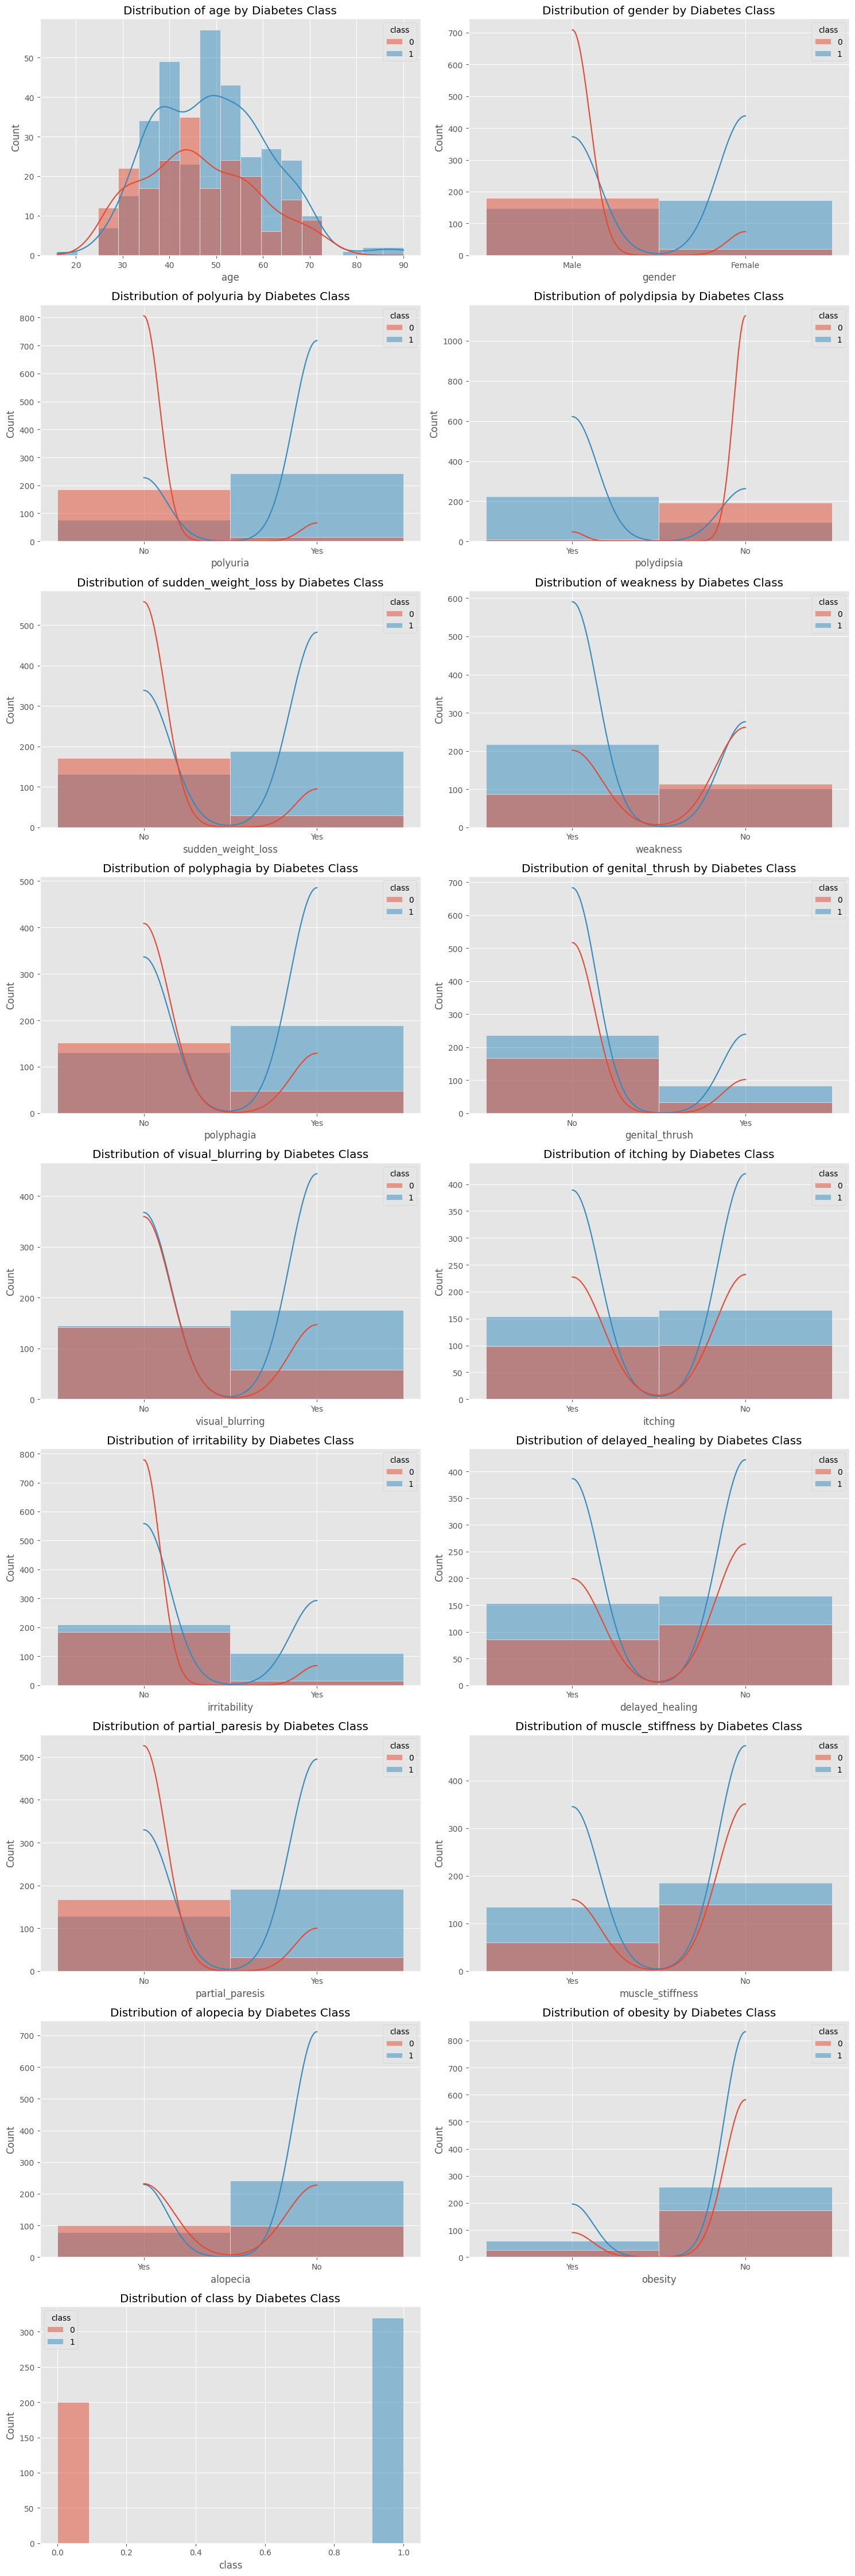

In [511]:
# Calculate number of features to plot
num_features = len(Diabetes.columns) - 1  # exclude 'class'

# Define grid size automatically
cols = 2
rows = math.ceil(num_features / cols)

# Visualize distributions of features
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()

for i, column in enumerate(Diabetes.columns[:-1]):  # Loop through features
    sns.histplot(data=Diabetes, x=column, hue='class', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column} by Diabetes Class')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Hide any unused subplots (if any)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


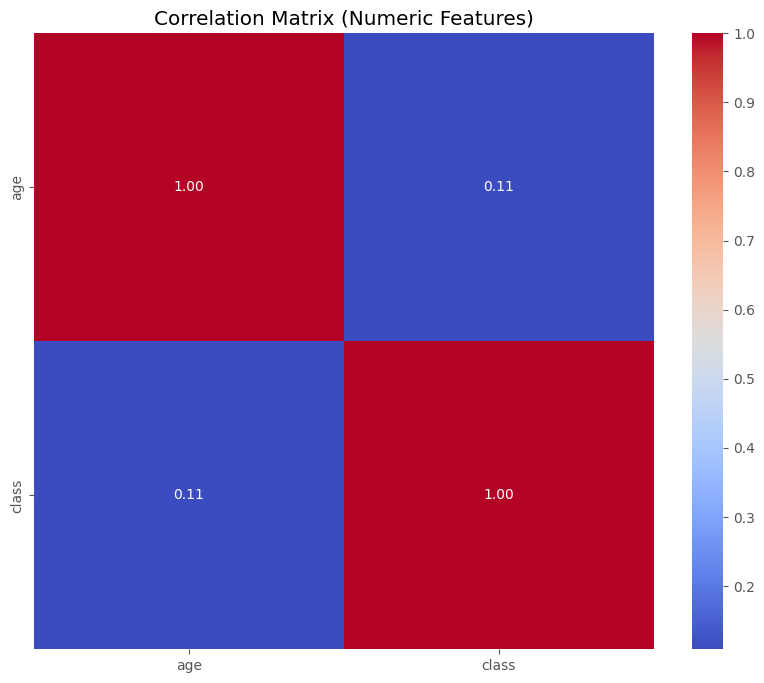

In [512]:
# Correlation matrix for only numeric columns
plt.figure(figsize=(10, 8))
correlation_matrix = Diabetes.select_dtypes(include=[np.number]).corr()  # <-- Only numeric columns
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Numeric Features)')
plt.show()

In [513]:
# Gender Distribution Analysis
gendis = px.histogram(Diabetes, x='gender', color='class', title="Positive/Negative count Vs Gender")
gendis.show()

In [514]:
# Create a cross-tabulation of gender vs class with percentage
pltbl= ['gender', 'class']
cm = sns.light_palette("green", as_cmap=True)
(round(pd.crosstab(Diabetes[pltbl[0]],Diabetes[pltbl[1]], normalize='columns') * 100,2)).style.background_gradient(cmap = cm)

# Analysis comment
print("Female patients have a higher positivity rate than male patients. We can safely conclude that this data set is biased toward female patients with a high positivity rate.")

Female patients have a higher positivity rate than male patients. We can safely conclude that this data set is biased toward female patients with a high positivity rate.


In [515]:
# Age Distribution Analysis
agehist= px.histogram(Diabetes, x='age', color="class", title="Distribution of Postive cases with Ages")
agehist.show()

# Analysis comment
print("The data is free of skew. A normal distribution can be seen. The majority of positive cases are between the ages of 32 and 69.")

The data is free of skew. A normal distribution can be seen. The majority of positive cases are between the ages of 32 and 69.


In [516]:
# Age vs Outcome Box Plot
genbox = px.box(Diabetes, y="age", x="class", color="gender", points="all", title= "Age Vs Positive/Negative")
genbox.show()

## Data Preprocessing

In [517]:
# Feature scaling (fixed)
for col in ['polyuria', 'polydipsia', 'weakness', 'obesity']:
    Diabetes[col] = Diabetes[col].map({'Yes': 1, 'No': 0})

#Select specific features
selected_features = ['age', 'polyuria', 'polydipsia', 'weakness', 'obesity']
X = Diabetes[selected_features]
y = LabelEncoder().fit_transform(Diabetes['class'])

# Now split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing complete.")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")


Data preprocessing complete.
Training set shape: (390, 5)
Testing set shape: (130, 5)


## ✨ Feature Engineering

In [518]:
print(Diabetes.columns)

Index(['age', 'gender', 'polyuria', 'polydipsia', 'sudden_weight_loss',
       'weakness', 'polyphagia', 'genital_thrush', 'visual_blurring',
       'itching', 'irritability', 'delayed_healing', 'partial_paresis',
       'muscle_stiffness', 'alopecia', 'obesity', 'class', 'class_label'],
      dtype='object')


In [519]:
# First, replace 'Yes'/'No' with 1/0
Diabetes = Diabetes.replace({'Yes': 1, 'No': 0})

# Now create the feature safely
Diabetes['Age_Obesity_Ratio'] = Diabetes['age'] / (Diabetes['obesity'] + 1)  # +1 to avoid divide by zero

print("Feature Engineering complete: 'Age_Obesity_Ratio' added.")


Feature Engineering complete: 'Age_Obesity_Ratio' added.


## 🔍 Class Imbalance Check

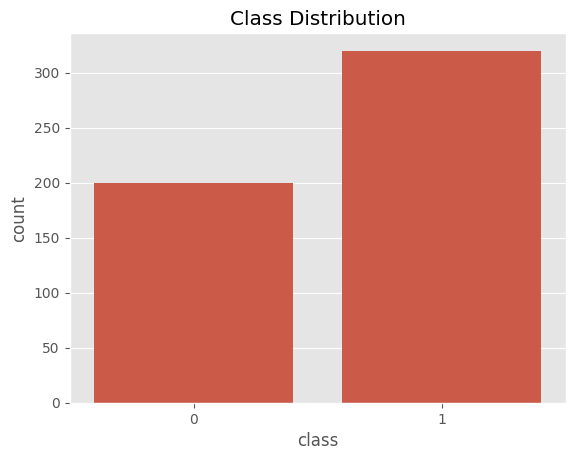

In [520]:
sns.countplot(data=Diabetes, x='class')
plt.title('Class Distribution')
plt.show()

## 🧪 Outlier Detection

In [521]:
# Check for unusually high ages (edge-case)
outliers = Diabetes[Diabetes['age'] > 100]
print(f"Potential outliers (Age > 100): {outliers.shape[0]}")

# Optionally, remove outliers
Diabetes = Diabetes[Diabetes['age'] <= 100]
print("Outliers removed where Age > 100.")

Potential outliers (Age > 100): 0
Outliers removed where Age > 100.


## 📊 ANOVA Test for Feature Significance

In [522]:

positive = Diabetes[Diabetes['class_label'] == 'Positive']['age']
negative = Diabetes[Diabetes['class_label'] == 'Negative']['age']

# Perform one-way ANOVA
f_stat, p_value = f_oneway(positive, negative)

print(f"Age ANOVA p-value: {p_value:.4f}")


Age ANOVA p-value: 0.0132


In [523]:
print(X_train.shape)
print(X_train.columns)

(390, 5)
Index(['age', 'polyuria', 'polydipsia', 'weakness', 'obesity'], dtype='object')


## 🔁 Pipeline and Cross-Validation

In [524]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),   
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', LogisticRegression())
])

scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Mean CV Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")

Mean CV Accuracy: 0.83 ± 0.03


In [525]:
print(f"Data shape: {X_train.shape}") 

Data shape: (390, 5)


In [526]:
params = {'pca__n_components': [2, 3, 4, 5]}
grid = GridSearchCV(pipeline, params, cv=5)
grid.fit(X_train, y_train)
print("Best PCA components:", grid.best_params_)

Best PCA components: {'pca__n_components': 4}


## 🛠 Consistency Fix & Validation Checks

In [527]:
# Check which columns are missing
missing_cols = [col for col in required_cols if col not in Diabetes.columns]
print(f"Missing columns: {missing_cols}")

# Check what columns are actually in the dataset
print(f"Available columns: {list(Diabetes.columns)}")

Missing columns: []
Available columns: ['age', 'gender', 'polyuria', 'polydipsia', 'sudden_weight_loss', 'weakness', 'polyphagia', 'genital_thrush', 'visual_blurring', 'itching', 'irritability', 'delayed_healing', 'partial_paresis', 'muscle_stiffness', 'alopecia', 'obesity', 'class', 'class_label', 'Age_Obesity_Ratio']


In [528]:
# Column existence validation
required_cols = ['age', 'obesity', 'class']
assert all(col in Diabetes.columns for col in required_cols), "Missing required columns!"

## 🔎 Pair Plot of Key Features

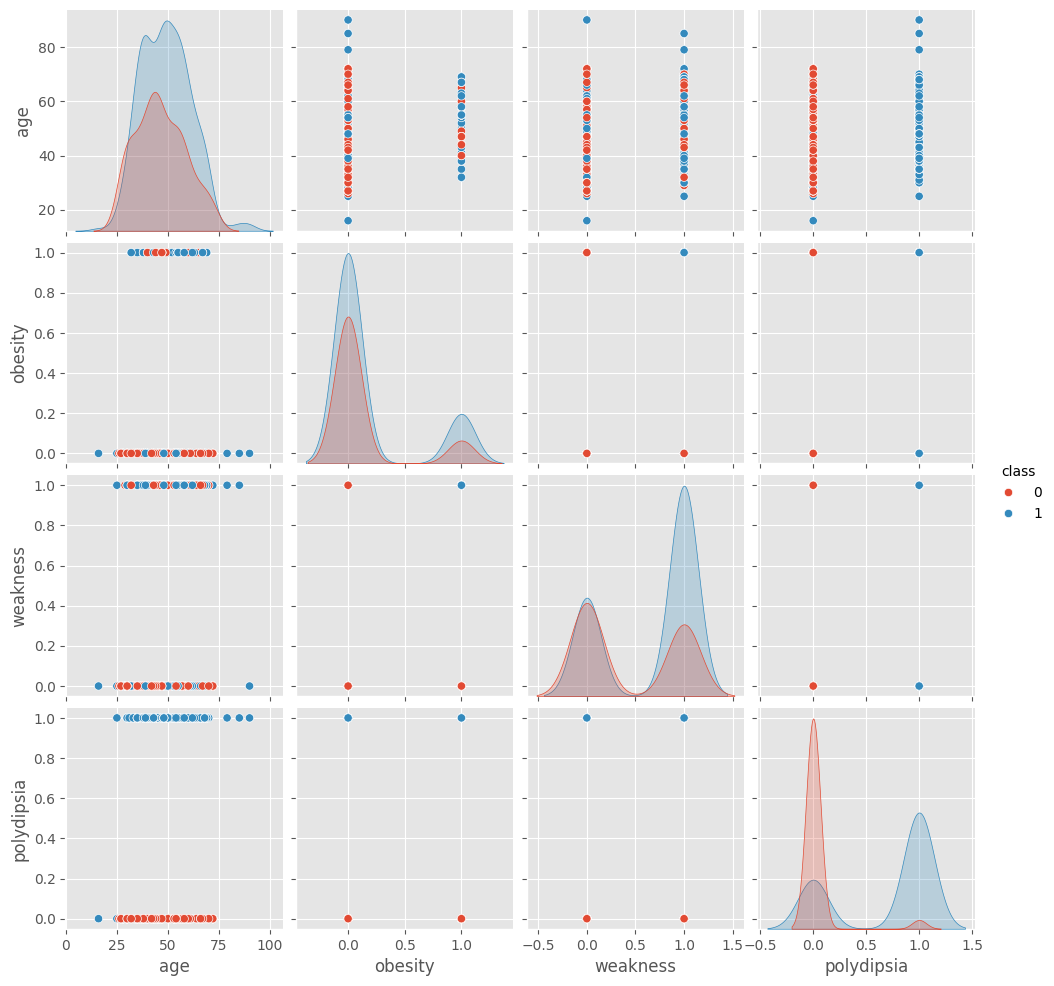

In [529]:
# Choose a subset of interesting columns
cols_to_plot = ['age', 'obesity', 'weakness', 'polydipsia', 'class']
sns.pairplot(Diabetes[cols_to_plot], hue='class', diag_kind='kde')
plt.show()

### Saving the processed DataFrame to a file

In [530]:
# Save the processed DataFrame to a file
Diabetes.to_csv('processed_diabetes.csv', index=False)
print("✔ Processed data saved as processed_diabetes.csv")

✔ Processed data saved as processed_diabetes.csv


In [533]:
# Save preprocessed train/test sets
joblib.dump((X_train_scaled, X_test_scaled, y_train, y_test), 'processed_data.pkl')
print("✔ Preprocessed train/test data saved to processed_data.pkl")

✔ Preprocessed train/test data saved to processed_data.pkl


In [535]:
try:
    rf_model = joblib.load('processed_data.pkl')
    print("Model loaded successfully")
except FileNotFoundError:
    print("Model file not found. Need to train the model first.")


Model loaded successfully
